# Tutorial: Visualización y Comparación de Modelos YOLO

En este notebook se visualiza la "máscara de verdad" (Ground Truth) de la imagen 139 del dataset COCO 2017 y se compara el rendimiento de diferentes versiones del modelo YOLO11.

In [17]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import pandas as pd
from pathlib import Path
from pycocotools.coco import COCO
from ultralytics import YOLO

In [18]:
ROOT_DIR = Path.cwd()
DATASET_DIR = ROOT_DIR / "dataset"

IMG_DIR = DATASET_DIR / "images" / "val2017"  
ANN_FILE = DATASET_DIR / "annotations" / "instances_val2017.json"
TEMP_DIR = ROOT_DIR / "temp_coco" / "val2017"

# Aseguramos que existan los directorios
IMG_DIR.mkdir(parents=True, exist_ok=True)

# ID de la imagen solicitada (139)
IMAGE_ID = 139
IMAGE_FILENAME = f"{IMAGE_ID:012d}.jpg"
IMAGE_PATH = IMG_DIR / IMAGE_FILENAME

# Asegurar que la imagen existe en el dataset (si no, intentar copiarla de temp)
if not IMAGE_PATH.exists():
    print(f"La imagen {IMAGE_FILENAME} no está en el subconjunto actual. Buscando en temporales...")
    temp_img_path = TEMP_DIR / IMAGE_FILENAME
    if temp_img_path.exists():
        shutil.copy(temp_img_path, IMAGE_PATH)
        print(f"Imagen copiada exitosamente a {IMAGE_PATH}")
    else:
        print(f"ADVERTENCIA: No se encontró la imagen {IMAGE_FILENAME}. Asegúrate de haber descargado el dataset.")
else:
    print(f"Imagen {IMAGE_FILENAME} encontrada.")

Imagen 000000000139.jpg encontrada.


loading annotations into memory...
Done (t=0.36s)
creating index...
index created!


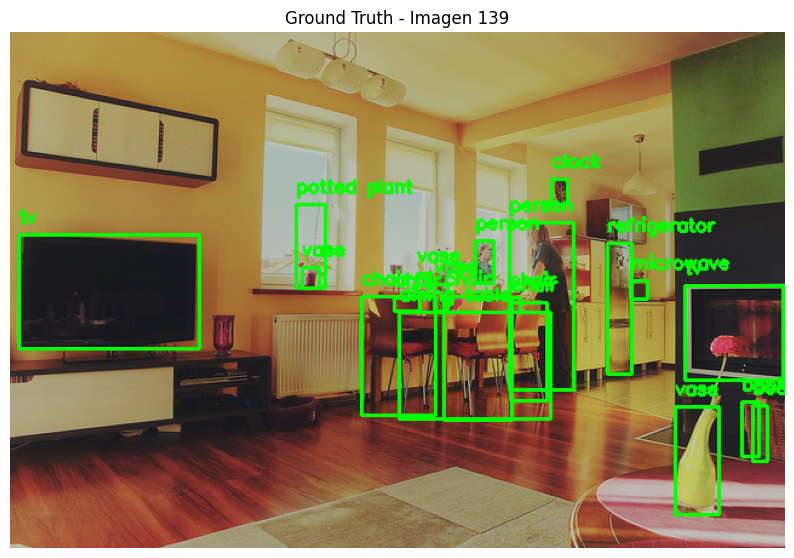

In [19]:
# --- Visualización del Ground Truth ---

# Cargar anotaciones COCO
coco = COCO(ANN_FILE)

# Cargar imagen con OpenCV
img = cv2.imread(str(IMAGE_PATH))
if img is None:
    raise FileNotFoundError(f"No se pudo leer la imagen en {IMAGE_PATH}")

img_gt = img.copy()

# Obtener anotaciones para la imagen 139
ann_ids = coco.getAnnIds(imgIds=IMAGE_ID)
anns = coco.loadAnns(ann_ids)

# Dibujar Bounding Boxes y Clases
for ann in anns:
    x, y, w, h = [int(v) for v in ann['bbox']]
    cat_id = ann['category_id']
    class_name = coco.loadCats(cat_id)[0]['name']
    
    # Rectángulo verde para Ground Truth
    cv2.rectangle(img_gt, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(img_gt, class_name, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Mostrar
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(img_gt, cv2.COLOR_BGR2RGB))
plt.title(f"Ground Truth - Imagen {IMAGE_ID}")
plt.axis('off')
plt.show()

In [20]:
# --- Predicciones con YOLO ---

model_sizes = ['n', 's', 'm', 'l', 'x']
best_model = None
max_detections = -1
best_result = None
best_model_name = ""

print("Ejecutando predicciones...")
for size in model_sizes:
    model_name = f"yolo11{size}"
    try:
        # Cargar modelo (se descargará si no existe)
        model = YOLO(f"{model_name}.pt")
        
        # Predecir
        results = model(IMAGE_PATH, verbose=False)
        result = results[0]
        
        num_detections = len(result.boxes)
        print(f"{model_name}: {num_detections} objetos detectados.")
        
        # Guardar el mejor modelo (el que detecta más objetos)
        if num_detections > max_detections:
            max_detections = num_detections
            best_model = model
            best_result = result
            best_model_name = model_name
            
    except Exception as e:
        print(f"Error con {model_name}: {e}")

print(f"\nMejor modelo: {best_model_name} con {max_detections} detecciones.")

Ejecutando predicciones...
yolo11n: 13 objetos detectados.
yolo11s: 14 objetos detectados.
yolo11m: 17 objetos detectados.
yolo11l: 17 objetos detectados.
yolo11x: 16 objetos detectados.

Mejor modelo: yolo11m con 17 detecciones.


Resultado guardado en comparison_139_yolo11m.jpg


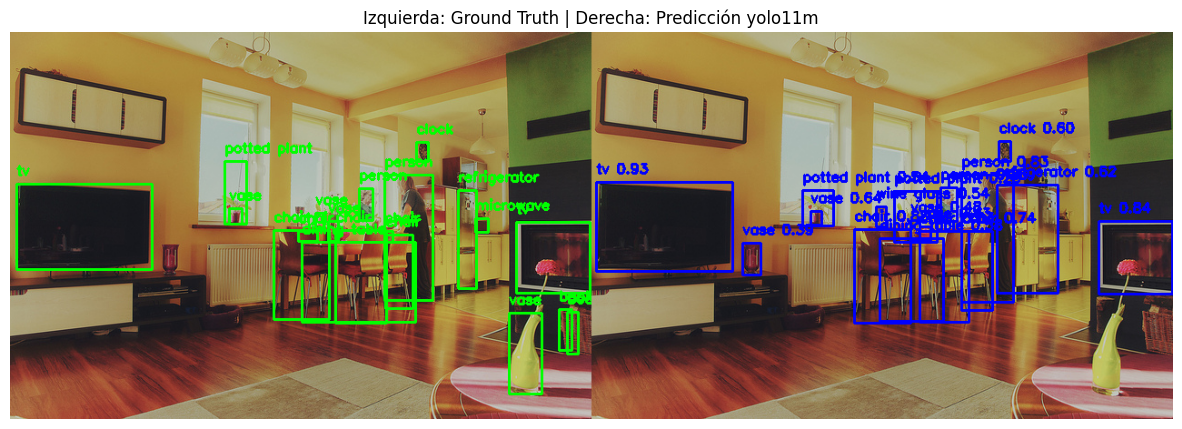

In [21]:
# --- Visualización: Mejor Modelo vs Ground Truth ---

img_pred = img.copy()

if best_result:
    boxes = best_result.boxes
    for box in boxes:
        # Coordenadas y confianza
        x1, y1, x2, y2 = [int(v) for v in box.xyxy[0]]
        conf = float(box.conf)
        cls_id = int(box.cls)
        class_name = best_model.names[cls_id]
        
        label = f"{class_name} {conf:.2f}"
        
        # Rectángulo azul para predicción
        cv2.rectangle(img_pred, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(img_pred, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

# Combinar imágenes lado a lado
combined = np.hstack((img_gt, img_pred))

# Guardar resultado
output_filename = f"comparison_{IMAGE_ID}_{best_model_name}.jpg"
cv2.imwrite(output_filename, combined)
print(f"Resultado guardado en {output_filename}")

# Mostrar
plt.figure(figsize=(15, 8))
plt.imshow(cv2.cvtColor(combined, cv2.COLOR_BGR2RGB))
plt.title(f"Izquierda: Ground Truth | Derecha: Predicción {best_model_name}")
plt.axis('off')
plt.show()

In [22]:
# --- Preparación para Evaluación (Conversión JSON -> YOLO TXT) ---
# Para usar model.val(), necesitamos las etiquetas en formato YOLO (.txt)

labels_dir = DATASET_DIR / "labels" / "val2017"
labels_dir.mkdir(parents=True, exist_ok=True)

print("Generando etiquetas en formato YOLO para el subconjunto...")

# Obtener IDs de las imágenes presentes en la carpeta de imágenes
present_images = [f for f in os.listdir(IMG_DIR) if f.endswith('.jpg')]

for img_file in present_images:
    # Extraer ID del nombre (000000000139.jpg -> 139)
    img_id = int(img_file.split('.')[0])
    
    # Obtener info de la imagen (ancho, alto)
    img_info = coco.loadImgs(img_id)[0]
    img_w = img_info['width']
    img_h = img_info['height']
    
    # Obtener anotaciones
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)
    
    txt_content = []
    for ann in anns:
        # COCO bbox: [x_top_left, y_top_left, width, height]
        x, y, w, h = ann['bbox']
        
        # YOLO bbox: [x_center, y_center, width, height] normalizado
        x_center = (x + w / 2) / img_w
        y_center = (y + h / 2) / img_h
        w_norm = w / img_w
        h_norm = h / img_h
        
        # Mapeo de categorías (COCO tiene IDs discontinuos, YOLO espera 0-79)
        # Ultralytics usa el orden estándar de COCO 80 clases.
        # Necesitamos mapear category_id de COCO al índice 0-79.
        # coco.getCatIds() devuelve los IDs reales. 
        # Crearemos un mapa simple si usamos el modelo preentrenado COCO.
        # Los modelos 'yolo11*.pt' están entrenados en COCO, así que usan el mapeo estándar.
        # El mapeo estándar suele ser: índice en la lista ordenada de IDs de COCO.
        
        cat_id = ann['category_id']
        # Lista de IDs de categorías COCO ordenados
        coco_cats = sorted(coco.getCatIds())
        cat_idx = coco_cats.index(cat_id)
        
        txt_content.append(f"{cat_idx} {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}")
        
    # Guardar archivo .txt
    txt_path = labels_dir / f"{img_file.replace('.jpg', '.txt')}"
    with open(txt_path, 'w') as f:
        f.write('\n'.join(txt_content))

print("Etiquetas generadas.")

# Crear archivo YAML para validación personalizada
yaml_content = f"""
path: {DATASET_DIR.as_posix()}
train: images/val2017 # No se usa para val, pero requerido
val: images/val2017

# Classes
names:
  0: person
  1: bicycle
  2: car
  3: motorcycle
  4: airplane
  5: bus
  6: train
  7: truck
  8: boat
  9: traffic light
  10: fire hydrant
  11: stop sign
  12: parking meter
  13: bench
  14: bird
  15: cat
  16: dog
  17: horse
  18: sheep
  19: cow
  20: elephant
  21: bear
  22: zebra
  23: giraffe
  24: backpack
  25: umbrella
  26: handbag
  27: tie
  28: suitcase
  29: frisbee
  30: skis
  31: snowboard
  32: sports ball
  33: kite
  34: baseball bat
  35: baseball glove
  36: skateboard
  37: surfboard
  38: tennis racket
  39: bottle
  40: wine glass
  41: cup
  42: fork
  43: knife
  44: spoon
  45: bowl
  46: banana
  47: apple
  48: sandwich
  49: orange
  50: broccoli
  51: carrot
  52: hot dog
  53: pizza
  54: donut
  55: cake
  56: chair
  57: couch
  58: potted plant
  59: bed
  60: dining table
  61: toilet
  62: tv
  63: laptop
  64: mouse
  65: remote
  66: keyboard
  67: cell phone
  68: microwave
  69: oven
  70: toaster
  71: sink
  72: refrigerator
  73: book
  74: clock
  75: vase
  76: scissors
  77: teddy bear
  78: hair drier
  79: toothbrush
"""

with open("custom_coco.yaml", "w") as f:
    f.write(yaml_content)

Generando etiquetas en formato YOLO para el subconjunto...
Etiquetas generadas.


In [23]:
# --- Evaluación Comparativa ---

metrics_list = []

print("Evaluando modelos en el subconjunto de validación...")
for size in model_sizes:
    model_name = f"yolo11{size}"
    try:
        model = YOLO(f"{model_name}.pt")
        
        # Ejecutar validación usando nuestro YAML personalizado
        metrics = model.val(data="custom_coco.yaml", split='val', verbose=False)
        
        # Extraer métricas clave
        map50 = metrics.box.map50
        map5095 = metrics.box.map
        
        metrics_list.append({
            "Model": model_name,
            "mAP50": map50,
            "mAP50-95": map5095
        })
        print(f"{model_name} -> mAP50: {map50:.4f}, mAP50-95: {map5095:.4f}")
        
    except Exception as e:
        print(f"Saltando evaluación para {model_name}: {e}")

# Mostrar tabla comparativa
if metrics_list:
    df_metrics = pd.DataFrame(metrics_list)
    print("\nComparación de Rendimiento:")
    print(df_metrics)

Evaluando modelos en el subconjunto de validación...
Ultralytics 8.4.5  Python-3.13.7 torch-2.9.1+cpu CPU (AMD Ryzen 7 5825U with Radeon Graphics)
YOLO11n summary (fused): 100 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 327.248.2 MB/s, size: 178.9 KB)
val: Scanning C:\Users\usuario\OneDrive\Desktop\AprendizajeAutomatico\practicas-aprendizaje\profundo\dataset\labels\val2017... 5000 images, 48 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 5000/5000 477.3it/s 10.5s<0.0s
val: New cache created: C:\Users\usuario\OneDrive\Desktop\AprendizajeAutomatico\practicas-aprendizaje\profundo\dataset\labels\val2017.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 313/313 1.2s/it 6:30<1.1s
                   all       5000      36781      0.652      0.502      0.546      0.391
Speed: 1.4ms preprocess, 68.0ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to C:\Users\us